In [1]:
import matplotlib.pyplot as plt
import numpy as np
from rich.progress import track
from scipy.stats import uniform

from centrex_trajectories import (
    Coordinates,
    Gravity,
    PropagationType,
    Velocities,
    propagate_trajectories,
    PropagationOptions,
)
from centrex_trajectories.particles import TlF
from centrex_trajectories.beamline_objects import (
    CircularAperture,
    ElectrostaticQuadrupoleLens,
    RectangularAperture,
    Section,
    Bore,
)
from centrex_trajectories.visualization import plot_beamline


In [2]:
plt.rcParams.update({"font.size": 14})

# Parameters

## Constants

Dimensions and distances here are taken from Oskari Timgren's thesis, section 8.2.4.

In [3]:
n_trajectories = 10_000_000
options = PropagationOptions(verbose=False, n_cores=8)
gravity = Gravity(0, -9.81, 0)
particle = TlF()


in_to_m = 25.4e-3

rc_length = 12.5 * in_to_m
spa_length = 12.5 * in_to_m
spb_length = 12.5 * in_to_m
interaction_length = 3.0
spc_length = 12.5 * in_to_m

aperture_cone_radius = 0.232 * in_to_m / 2
aperture_4k_radius = 1 * in_to_m / 2
aperture_40k_radius = 1 * in_to_m / 2
aperture_beambox_radius = 4 * in_to_m / 2
aperture_interaction_width = 1.8e-2
aperture_interaction_height = 10e-2
aperture_det_width = 1e-2
aperture_det_height = 3e-2

eql_radius = 1.75 * in_to_m / 2
eql_voltage = 30_000  # V
eql_length = 0.6  # m

interaction_electrode_separation = 2e-2
interaction_electrode_height = 10e-2

v_forward = 200  # m/s
sigma_v_forward = 13  # m/s
sigma_v_transverse = 57  # m/s

freezing_diameter = 0.02
z_freezing = 0.0 * in_to_m

# measured
v_forward = 184  # m/s
sigma_v_forward = 16  # m/s
sigma_v_transverse = 39.4  # m/s


In [4]:
# origin = Coordinates(
#     x=np.random.randn(n_trajectories) * freezing_diameter / 2,
#     y=np.random.randn(n_trajectories) * freezing_diameter / 2,
#     z=np.zeros(n_trajectories) + z_freezing,
# )

theta = uniform.rvs(size=n_trajectories) * 2 * np.pi
r = np.sqrt(uniform.rvs(size=n_trajectories)) * freezing_diameter / 2
origin = Coordinates(
    x=r * np.cos(theta), y=r * np.sin(theta), z=np.full(n_trajectories, z_freezing)
)
del theta, r

velocities = Velocities(
    vx=np.random.randn(n_trajectories) * sigma_v_transverse,
    vy=np.random.randn(n_trajectories) * sigma_v_transverse,
    vz=np.random.randn(n_trajectories) * sigma_v_forward + v_forward,
)


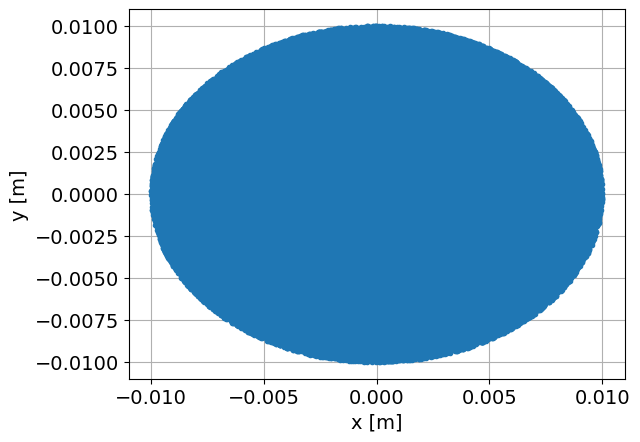

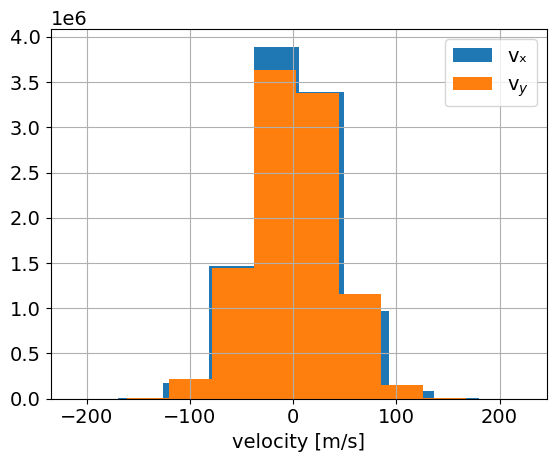

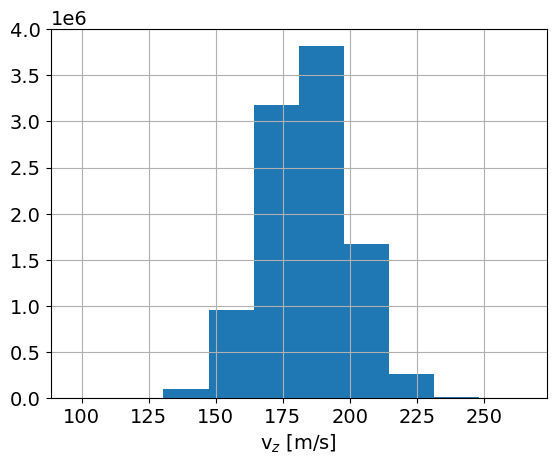

In [5]:
fig, ax = plt.subplots()
ax.plot(origin.x[:100_000], origin.y[:100_000], ".")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.grid()

fig, ax = plt.subplots()
ax.hist(velocities.vx, label="vₓ")
ax.hist(velocities.vy, label="v$_y$")
ax.set_xlabel("velocity [m/s]")
ax.legend()
ax.grid()

fig, ax = plt.subplots()
ax.hist(velocities.vz)
ax.set_xlabel("v$_z$ [m/s]")

ax.grid()


## Section generation functions

In [6]:
def calculate_distances(
    eql_length: float,
) -> tuple[float, float, float, float, float, float, float, float, float, float]:
    shield4k_distance = (0.325 + 1 + 0.375) * in_to_m
    shield40k_distance = shield4k_distance + (0.25 + 1.25) * in_to_m
    beambox_distance = shield40k_distance + (0.25 + 2.5) * in_to_m
    rc_distance = beambox_distance + 0.75 * in_to_m
    spa_distance = rc_distance + rc_length
    eql_distance = spa_distance + spa_length
    spb_distance = eql_distance + eql_length
    interaction_distance = spb_distance + spb_length
    spc_distance = interaction_distance + interaction_length
    det_distance = spc_distance + spc_length

    return (
        shield4k_distance,
        shield40k_distance,
        beambox_distance,
        rc_distance,
        spa_distance,
        eql_distance,
        spb_distance,
        interaction_distance,
        spc_distance,
        det_distance,
    )


In [7]:
from centrex_trajectories.beamline_objects import PlateElectrodes


def generate_sections(
    eql_length: float,
    eql_radius: float = eql_radius,
    eql_voltage: float = eql_voltage,
) -> (
    tuple[
        Section,
        Section,
        Section,
        Section,
        Section,
        Section,
        ElectrostaticQuadrupoleLens,
        Section,
        Section,
        Section,
        Section,
    ]
    | tuple[
        Section,
        Section,
        Section,
        Section,
        Section,
        Section,
        Section,
        Section,
        Section,
        Section,
    ]
):
    distance_offset = (
        1e-3  # apertures at the same location as a section start will lead to issues
    )
    (
        shield4k_distance,
        shield40k_distance,
        beambox_distance,
        rc_distance,
        spa_distance,
        eql_distance,
        spb_distance,
        interaction_distance,
        spc_distance,
        det_distance,
    ) = calculate_distances(eql_length)

    cone = Section(
        name="Conical Aperture",
        objects=[],
        # objects=[CircularAperture(0, 0, 0.325 * in_to_m, r=aperture_cone_radius)],
        start=0,
        stop=shield4k_distance - distance_offset,
        save_collisions=False,
        propagation_type=PropagationType.ballistic,
    )

    fourK = Section(
        name="4K shield",
        objects=[CircularAperture(0, 0, shield4k_distance, aperture_4k_radius)],
        start=shield4k_distance,
        stop=shield40k_distance - distance_offset,
        save_collisions=False,
        propagation_type=PropagationType.ballistic,
    )

    fourtyK = Section(
        name="40K shield",
        objects=[CircularAperture(0, 0, shield40k_distance, aperture_40k_radius)],
        start=shield40k_distance - distance_offset,
        stop=beambox_distance - distance_offset,
        save_collisions=False,
        propagation_type=PropagationType.ballistic,
    )

    beambox = Section(
        name="beambox",
        objects=[CircularAperture(0, 0, beambox_distance, aperture_beambox_radius)],
        start=beambox_distance - distance_offset,
        stop=rc_distance - distance_offset,
        save_collisions=False,
        propagation_type=PropagationType.ballistic,
    )

    rc = Section(
        name="RC",
        objects=[],
        start=rc_distance - distance_offset,
        stop=spa_distance - distance_offset,
        save_collisions=False,
        propagation_type=PropagationType.ballistic,
    )

    spa = Section(
        name="SPA",
        objects=[
            CircularAperture(0, 0, eql_distance - 2 * distance_offset, eql_radius)
        ],  # insert an aperture to limit throughput to lens
        start=spa_distance - distance_offset,
        stop=eql_distance,
        save_collisions=False,
        propagation_type=PropagationType.ballistic,
    )

    eql = ElectrostaticQuadrupoleLens(
        name="EQL",
        objects=[Bore(x=0, y=0, z=eql_distance, length=eql_length, radius=eql_radius)],
        start=eql_distance,
        stop=spb_distance,
        V=eql_voltage,
        R=eql_radius,
        save_collisions=True,
    )

    spb = Section(
        name="SPB",
        objects=[
            RectangularAperture(
                0,
                0,
                interaction_distance - 1.5 * distance_offset,
                aperture_interaction_width,
                aperture_interaction_height,
            )
        ],
        start=spb_distance,
        stop=interaction_distance - distance_offset,
        save_collisions=False,
        propagation_type=PropagationType.ballistic,
    )

    interaction = Section(
        name="Interaction",
        objects=[
            PlateElectrodes(
                0,
                0,
                interaction_distance - distance_offset,
                interaction_length,
                interaction_electrode_height,
                interaction_electrode_separation,
            )
        ],
        start=interaction_distance - distance_offset,
        stop=spc_distance - distance_offset,
        save_collisions=False,
        propagation_type=PropagationType.ballistic,
    )

    spc = Section(
        name="SPC",
        objects=[],
        start=spc_distance - distance_offset,
        stop=det_distance - distance_offset,
        save_collisions=False,
        propagation_type=PropagationType.ballistic,
    )

    det = Section(
        name="DET",
        objects=[
            RectangularAperture(
                0, 0, det_distance, aperture_det_width, aperture_det_height
            )
        ],
        start=det_distance - distance_offset,
        stop=det_distance + 1e-3,
        save_collisions=True,
        propagation_type=PropagationType.ballistic,
    )

    if eql_length != 0:
        return (cone, fourK, fourtyK, beambox, rc, spa, eql, spb, interaction, spc, det)
    else:
        return (cone, fourK, fourtyK, beambox, rc, spa, spb, interaction, spc, det)


# Trajectories

## With EQL

In [8]:
sections_lens = generate_sections(eql_length, eql_radius, eql_voltage)
section_data_lens, trajectories_lens = propagate_trajectories(
    sections_lens,
    origin,
    velocities,
    particle,
    force=gravity,
    options=options,
)


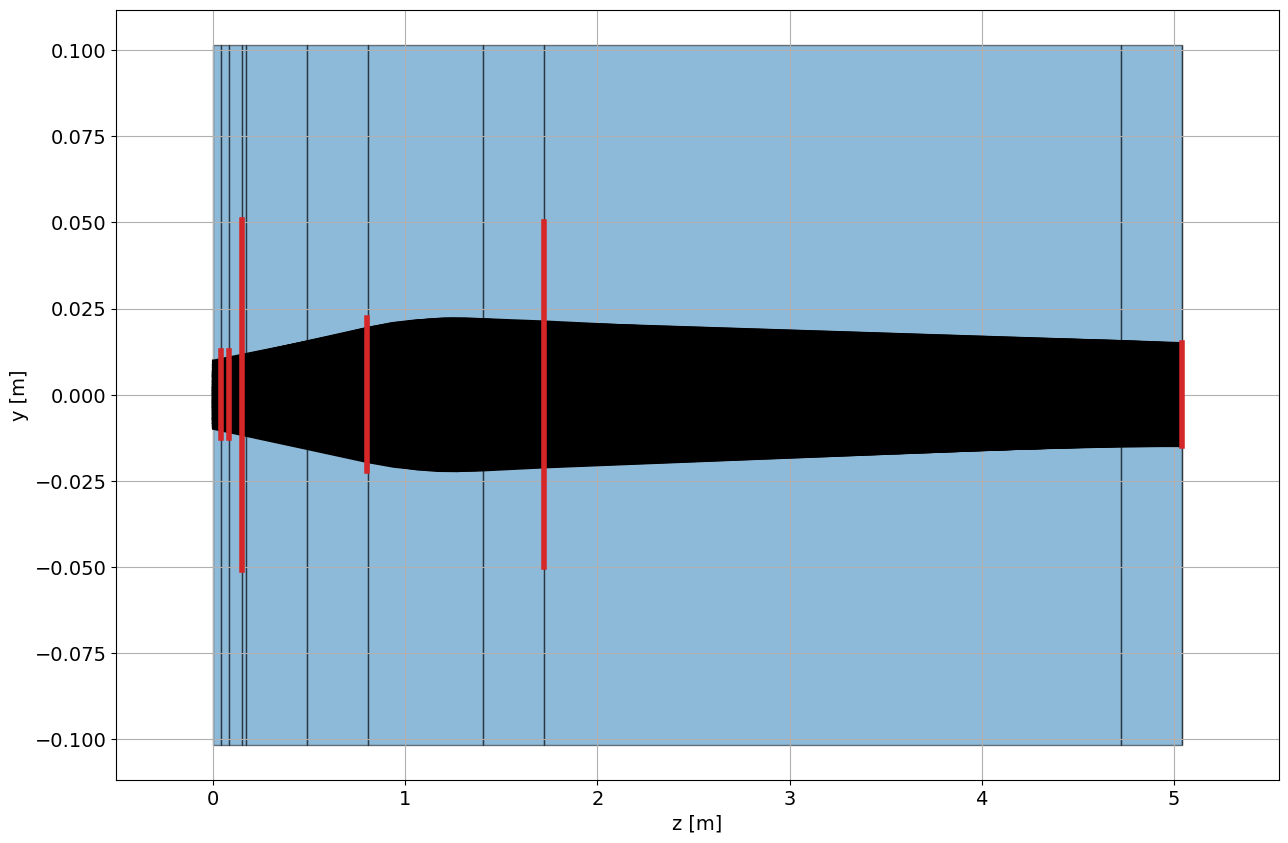

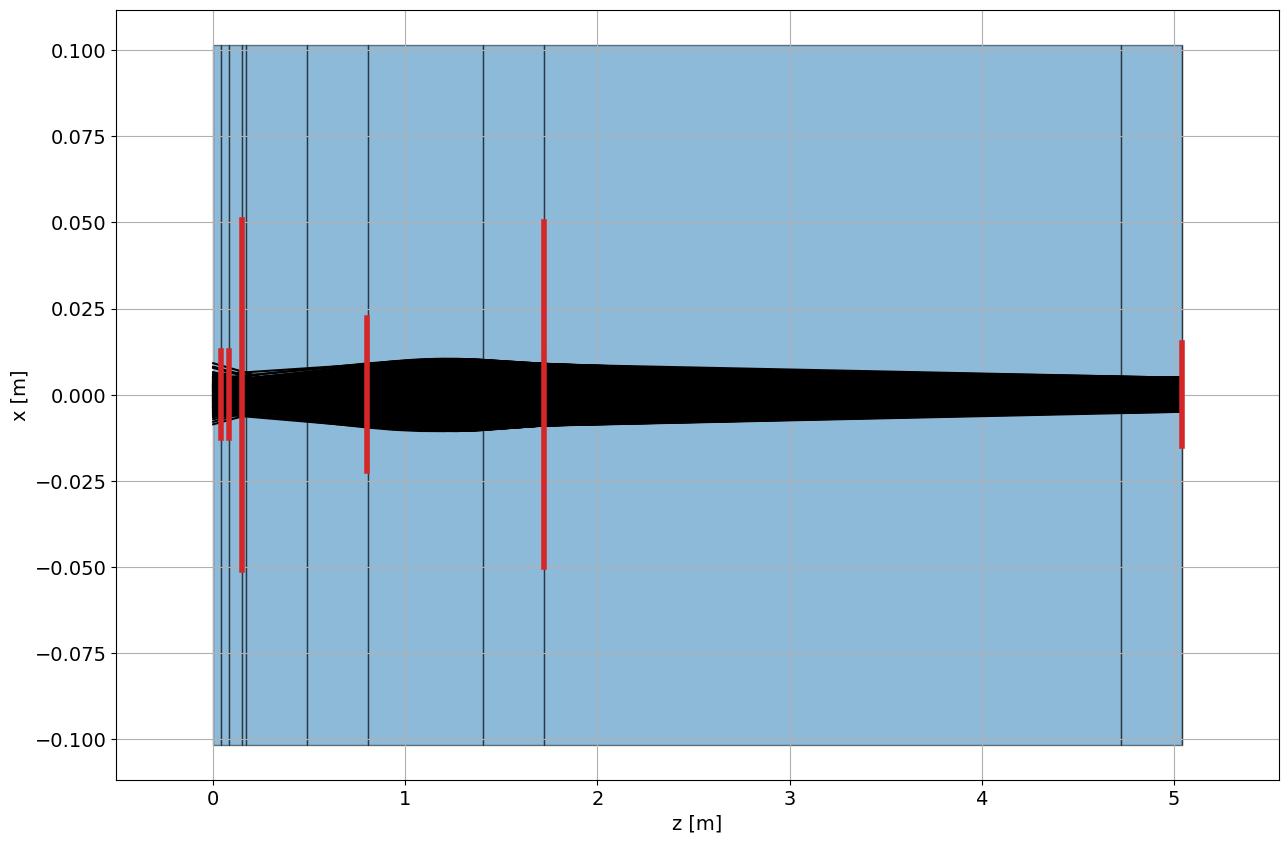

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))
for idt, traj in trajectories_lens.items():
    ax.plot(traj.z, traj.y, color="k")

plot_beamline(sections_lens, ax=ax)

ax.set_xlabel("z [m]")
ax.set_ylabel("y [m]")

ax.grid(True)

fig, ax = plt.subplots(figsize=(15, 10))
for idt, traj in trajectories_lens.items():
    ax.plot(traj.z, traj.x, color="k")

plot_beamline(sections_lens, ax=ax)

ax.set_xlabel("z [m]")
ax.set_ylabel("x [m]")

ax.grid(True)


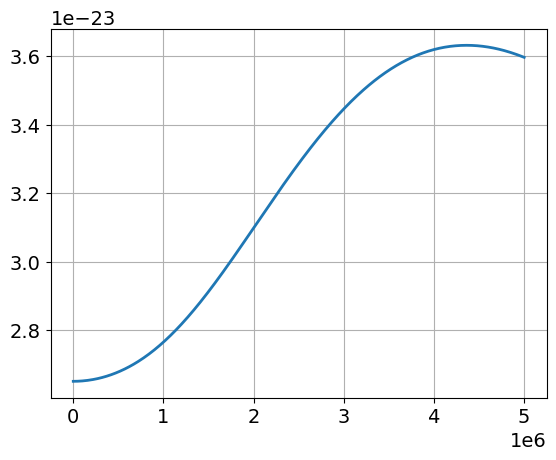

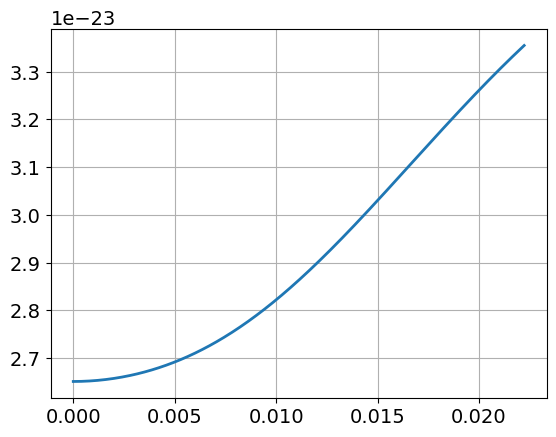

In [10]:
eql = sections_lens[6]

r = np.linspace(0, eql_radius, 501)
Ez = np.linspace(0, 50e5, 501)

fig, ax = plt.subplots()
ax.plot(Ez, eql.stark_potential_E(Ez), lw=2)
ax.grid()


fig, ax = plt.subplots()
ax.plot(r, eql.stark_potential(r, np.zeros(r.shape), np.zeros(r.shape)), lw=2)
ax.grid()


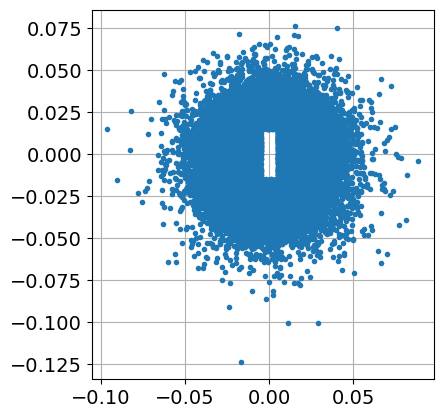

In [11]:
x = section_data_lens[-1].saved_collisions[0][0].x
y = section_data_lens[-1].saved_collisions[0][0].y
fig, ax = plt.subplots()
ax.plot(x, y, ".")
ax.set_aspect(1.0)
ax.grid()


## With EQL at 0 V

In [12]:
sections_lens_0V = generate_sections(eql_length, eql_radius, 0)
section_data_lens_0V, trajectories_lens_0V = propagate_trajectories(
    sections_lens_0V,
    origin,
    velocities,
    particle,
    force=gravity,
    options=options,
)


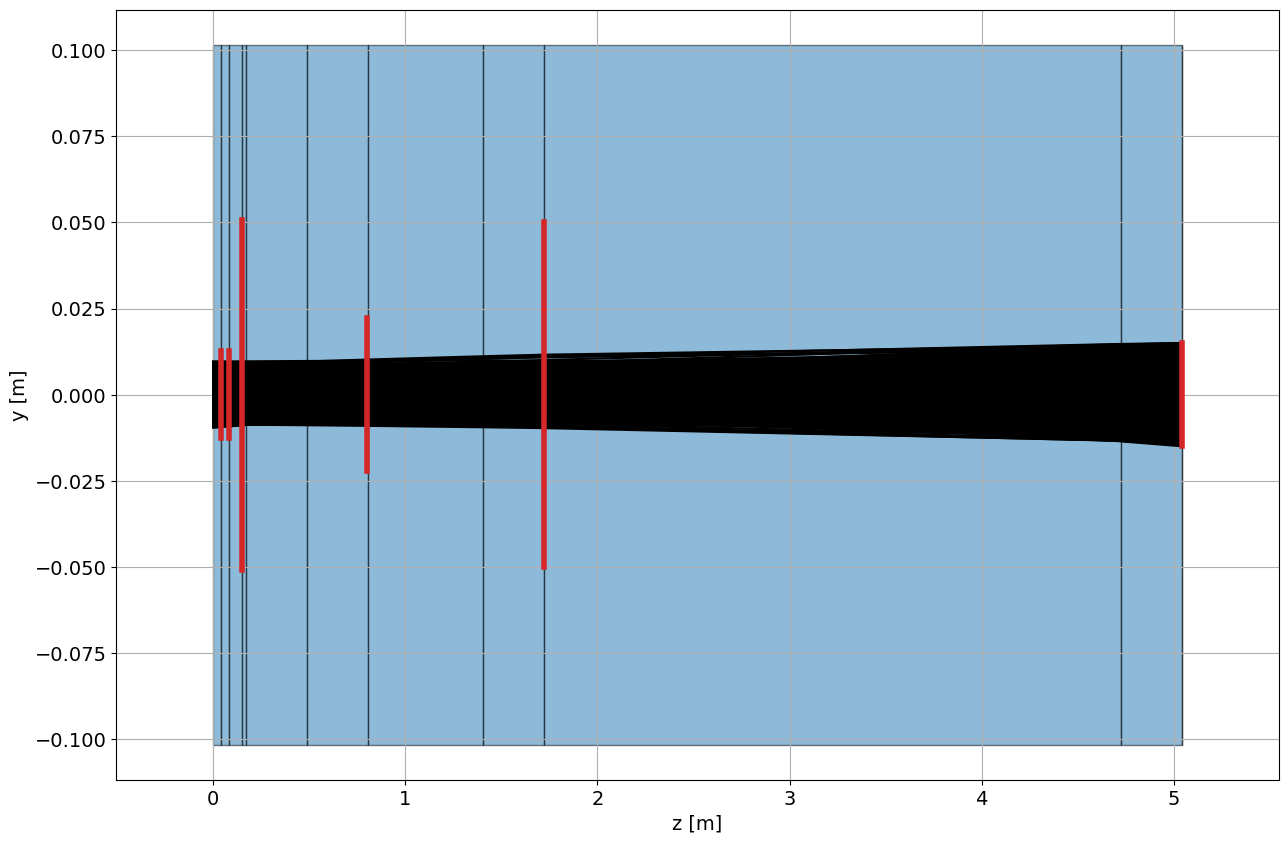

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))
for idt, traj in trajectories_lens_0V.items():
    ax.plot(traj.z, traj.y, color="k")

plot_beamline(sections_lens_0V, ax=ax)

ax.set_xlabel("z [m]")
ax.set_ylabel("y [m]")

ax.grid(True)


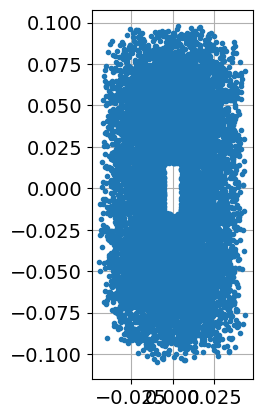

In [14]:
x = section_data_lens_0V[-1].saved_collisions[0][0].x
y = section_data_lens_0V[-1].saved_collisions[0][0].y
fig, ax = plt.subplots()
ax.plot(x, y, ".")
ax.set_aspect(1.0)
ax.grid()


## Gain with EQL at 0 V

In [15]:
print(
    f"lens gain = {section_data_lens[-1].survived / section_data_lens_0V[-1].survived:.2f}"
)


lens gain = 4.97


## Without EQL

In [16]:
sections = generate_sections(0, eql_radius, eql_voltage)
section_data, trajectories = propagate_trajectories(
    sections,
    origin,
    velocities,
    particle,
    force=gravity,
    options=options,
)


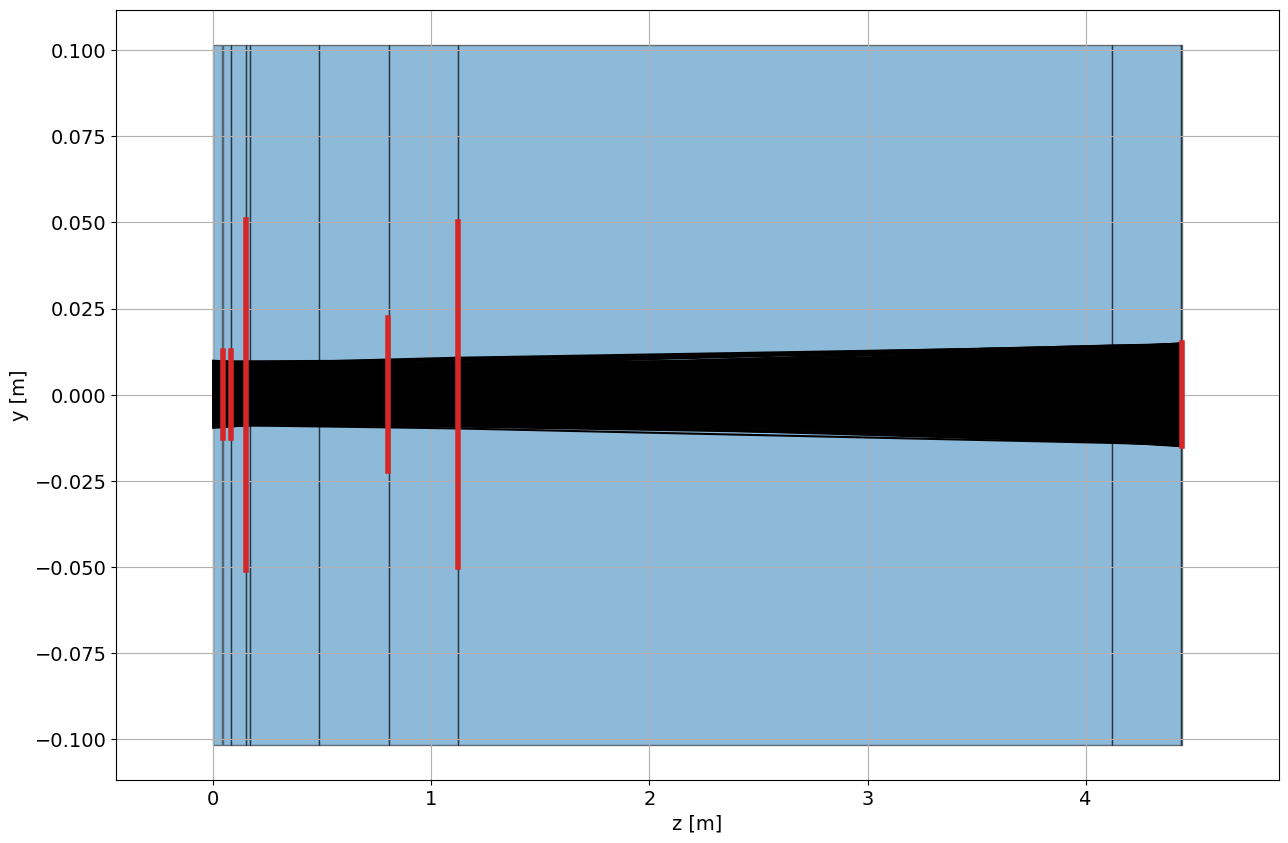

In [17]:
fig, ax = plt.subplots(figsize=(15, 10))
for idt, traj in trajectories.items():
    ax.plot(traj.z, traj.y, color="k")

plot_beamline(sections, ax=ax)

ax.set_xlabel("z [m]")
ax.set_ylabel("y [m]")

ax.grid(True)


## Gain with EQL removed

In [18]:
print(f"lens gain = {section_data_lens[-1].survived / section_data[-1].survived:.2f}")

lens gain = 3.83


## Remove EQL and SPB
SPB is not required when the lens is not used

In [19]:
def generate_sections_no_lens_spb() -> (
    tuple[
        Section,
        Section,
        Section,
        Section,
        Section,
        Section,
        Section,
        Section,
        Section,
    ]
):
    distance_offset = (
        1e-3  # apertures at the same location as a section start will lead to issues
    )
    (
        shield4k_distance,
        shield40k_distance,
        beambox_distance,
        rc_distance,
        spa_distance,
        eql_distance,
        spb_distance,
        interaction_distance,
        spc_distance,
        det_distance,
    ) = calculate_distances(eql_length=0)
    # remove SPB length from sections after SPB
    spb_length = interaction_distance - spb_distance
    interaction_distance -= spb_length
    spc_distance -= spb_length
    det_distance -= spb_length

    cone = Section(
        name="Conical Aperture",
        objects=[CircularAperture(0, 0, 0.325 * in_to_m, r=aperture_cone_radius)],
        start=0,
        stop=shield4k_distance - distance_offset,
        save_collisions=False,
        propagation_type=PropagationType.ballistic,
    )

    fourK = Section(
        name="4K shield",
        objects=[CircularAperture(0, 0, shield4k_distance, aperture_4k_radius)],
        start=shield4k_distance,
        stop=shield40k_distance - distance_offset,
        save_collisions=False,
        propagation_type=PropagationType.ballistic,
    )

    fourtyK = Section(
        name="40K shield",
        objects=[CircularAperture(0, 0, shield40k_distance, aperture_40k_radius)],
        start=shield40k_distance - distance_offset,
        stop=beambox_distance - distance_offset,
        save_collisions=False,
        propagation_type=PropagationType.ballistic,
    )

    beambox = Section(
        name="beambox",
        objects=[CircularAperture(0, 0, beambox_distance, aperture_beambox_radius)],
        start=beambox_distance - distance_offset,
        stop=rc_distance - distance_offset,
        save_collisions=False,
        propagation_type=PropagationType.ballistic,
    )

    rc = Section(
        name="RC",
        objects=[],
        start=rc_distance - distance_offset,
        stop=spa_distance - distance_offset,
        save_collisions=False,
        propagation_type=PropagationType.ballistic,
    )

    spa = Section(
        name="SPA",
        objects=[
            RectangularAperture(
                0,
                0,
                interaction_distance - 1.5 * distance_offset,
                aperture_interaction_width,
                aperture_interaction_height,
            )
        ],
        start=spa_distance - distance_offset,
        stop=interaction_distance - distance_offset,
        save_collisions=False,
        propagation_type=PropagationType.ballistic,
    )

    interaction = Section(
        name="Interaction",
        objects=[
            PlateElectrodes(
                0,
                0,
                interaction_distance - distance_offset,
                interaction_length,
                interaction_electrode_height,
                interaction_electrode_separation,
            )
        ],
        start=interaction_distance - distance_offset,
        stop=spc_distance - distance_offset,
        save_collisions=False,
        propagation_type=PropagationType.ballistic,
    )

    spc = Section(
        name="SPC",
        objects=[],
        start=spc_distance - distance_offset,
        stop=det_distance - distance_offset,
        save_collisions=False,
        propagation_type=PropagationType.ballistic,
    )

    det = Section(
        name="DET",
        objects=[
            RectangularAperture(
                0, 0, det_distance, aperture_det_width, aperture_det_height
            )
        ],
        start=det_distance - distance_offset,
        stop=det_distance + 1e-3,
        save_collisions=True,
        propagation_type=PropagationType.ballistic,
    )

    return (cone, fourK, fourtyK, beambox, rc, spa, interaction, spc, det)


In [20]:
sections_noeql_nodspb = generate_sections_no_lens_spb()
section_data_noeql_nospb, trajectories_noeql_nospb = propagate_trajectories(
    sections_noeql_nodspb,
    origin,
    velocities,
    particle,
    force=gravity,
    options=options,
)


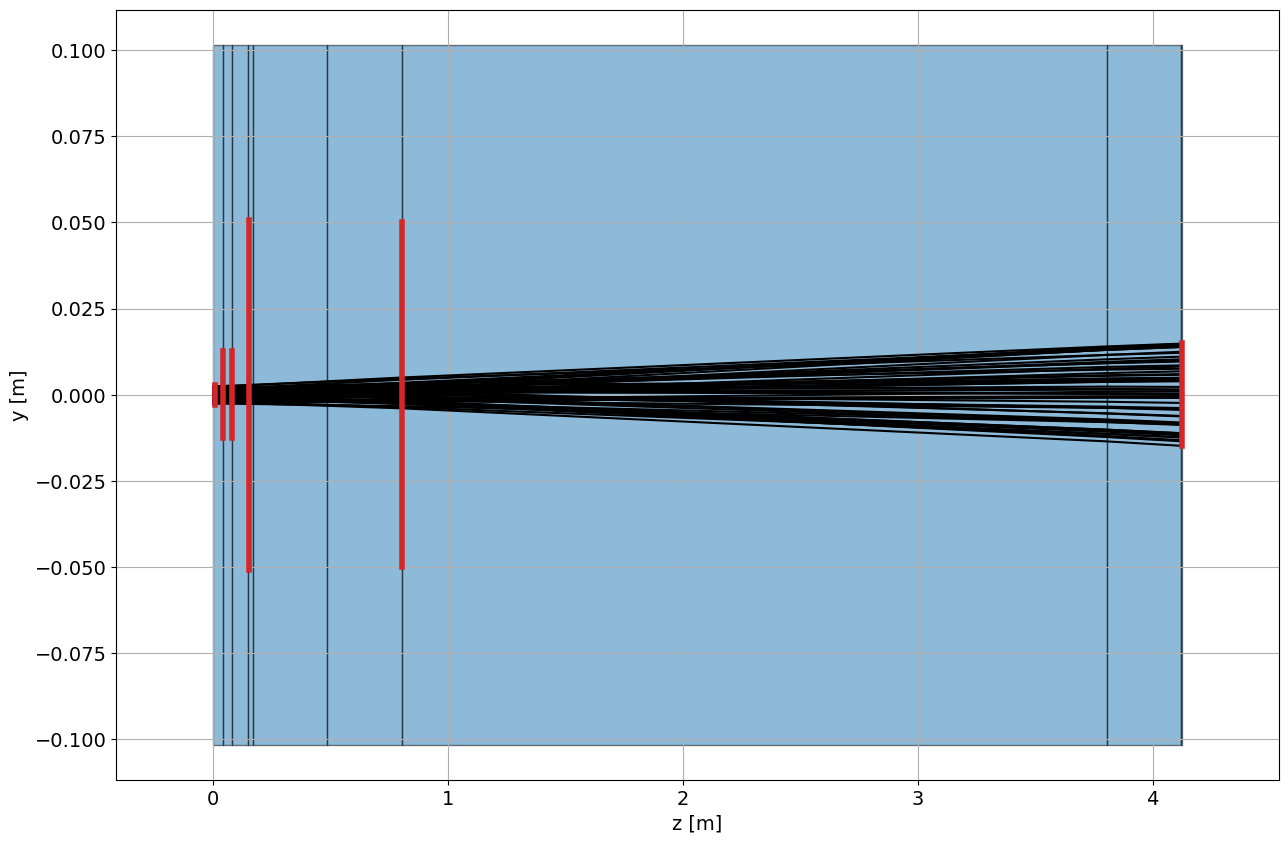

In [21]:
fig, ax = plt.subplots(figsize=(15, 10))
for idt, traj in trajectories_noeql_nospb.items():
    ax.plot(traj.z, traj.y, color="k")

plot_beamline(sections_noeql_nodspb, ax=ax)

ax.set_xlabel("z [m]")
ax.set_ylabel("y [m]")

ax.grid(True)


## Gain with EQL and SPB removed

In [22]:
print(
    f"lens gain = {section_data_lens[-1].survived / section_data_noeql_nospb[-1].survived:.2f}"
)


lens gain = 34.63


# Scan Lens Voltage

In [23]:
survived = []
for Vi in track(np.linspace(0e3, 30e3, 16)):
    secs = generate_sections(eql_length, eql_radius, Vi)
    sec_dat, trajs = propagate_trajectories(
        secs,
        origin,
        velocities,
        particle,
        force=gravity,
        options=options,
    )
    survived.append((Vi, sec_dat[-1].survived))


Output()

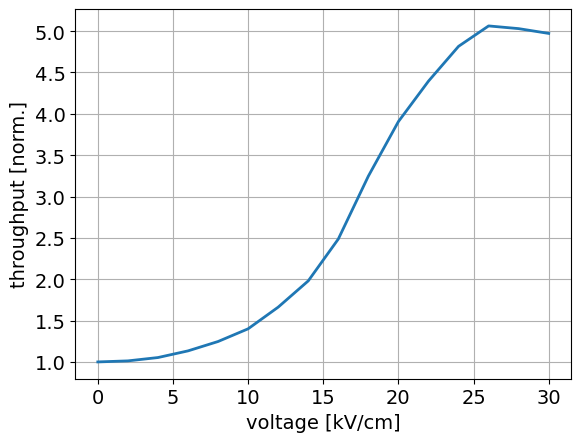

In [24]:
x, y = np.array(list(zip(*survived)))

fig, ax = plt.subplots()
ax.plot(x / 1_000, y / y[0], lw=2)
ax.set_xlabel("voltage [kV/cm]")
ax.set_ylabel("throughput [norm.]")
ax.grid()
